In [2]:
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
img_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
        transforms.Lambda(lambda x: x.to(device)),
    ]
)

trn_ds = MNIST("data/mnist", transform=img_transform, train=True, download=True)
val_ds = MNIST("data/mnist", transform=img_transform, train=False, download=True)

batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
# 增加批量归一化
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
from torchinfo import summary

model = ConvAutoEncoder().to(device)
summary(model, input_size=(1, 1, 28, 28), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
ConvAutoEncoder                          [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 64, 2, 2]             --
│    └─Conv2d: 2-1                       [1, 32, 10, 10]           320
│    └─BatchNorm2d: 2-2                  [1, 32, 10, 10]           64
│    └─ReLU: 2-3                         [1, 32, 10, 10]           --
│    └─MaxPool2d: 2-4                    [1, 32, 5, 5]             --
│    └─Conv2d: 2-5                       [1, 64, 3, 3]             18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 3, 3]             128
│    └─ReLU: 2-7                         [1, 64, 3, 3]             --
│    └─MaxPool2d: 2-8                    [1, 64, 2, 2]             --
├─Sequential: 1-2                        [1, 1, 28, 28]            --
│    └─ConvTranspose2d: 2-9              [1, 32, 5, 5]             18,464
│    └─BatchNorm2d: 2-10                 [1, 32, 5, 5]             64
│    

In [6]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss


model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [7]:
num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix + 1) / N), trn_loss=loss, end="\r")

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix + 1) / N), val_loss=loss, end="\r")

    log.report_avgs(epoch + 1)

/home/xujialiu/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/xujialiu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


EPOCH: 1.000  val_loss: 0.082  trn_loss: 0.280  (16.96s - 67.85s remaining)
EPOCH: 2.000  val_loss: 0.059  trn_loss: 0.069  (34.09s - 51.13s remaining)
EPOCH: 3.000  val_loss: 0.050  trn_loss: 0.056  (48.19s - 32.13s remaining)
EPOCH: 4.000  val_loss: 0.047  trn_loss: 0.049  (63.70s - 15.92s remaining)
EPOCH: 5.000  val_loss: 0.043  trn_loss: 0.046  (80.88s - 0.00s remaining)


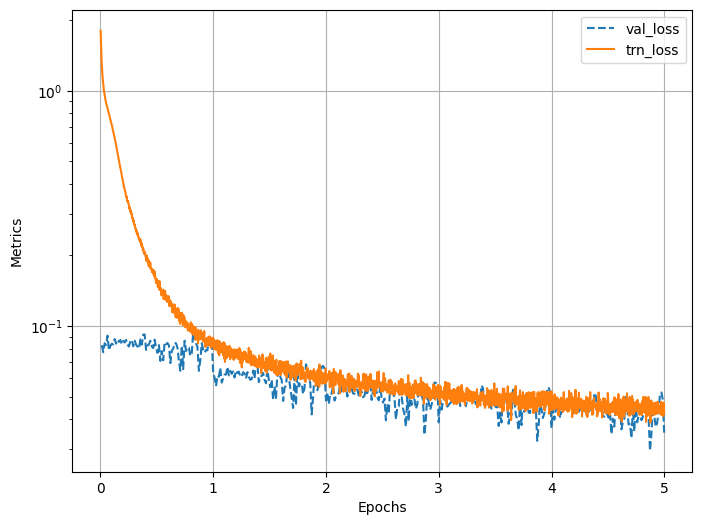

In [8]:
log.plot(log=True)

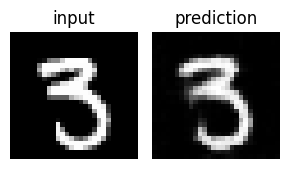

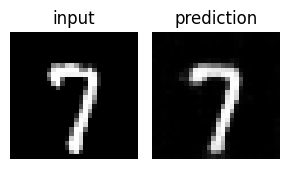

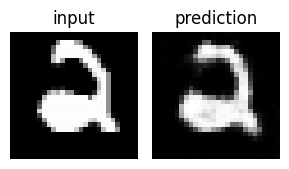

In [9]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3, 3))
    show(im[0], ax=ax[0], title="input")
    show(_im[0], ax=ax[1], title="prediction")
    plt.tight_layout()
    plt.show()

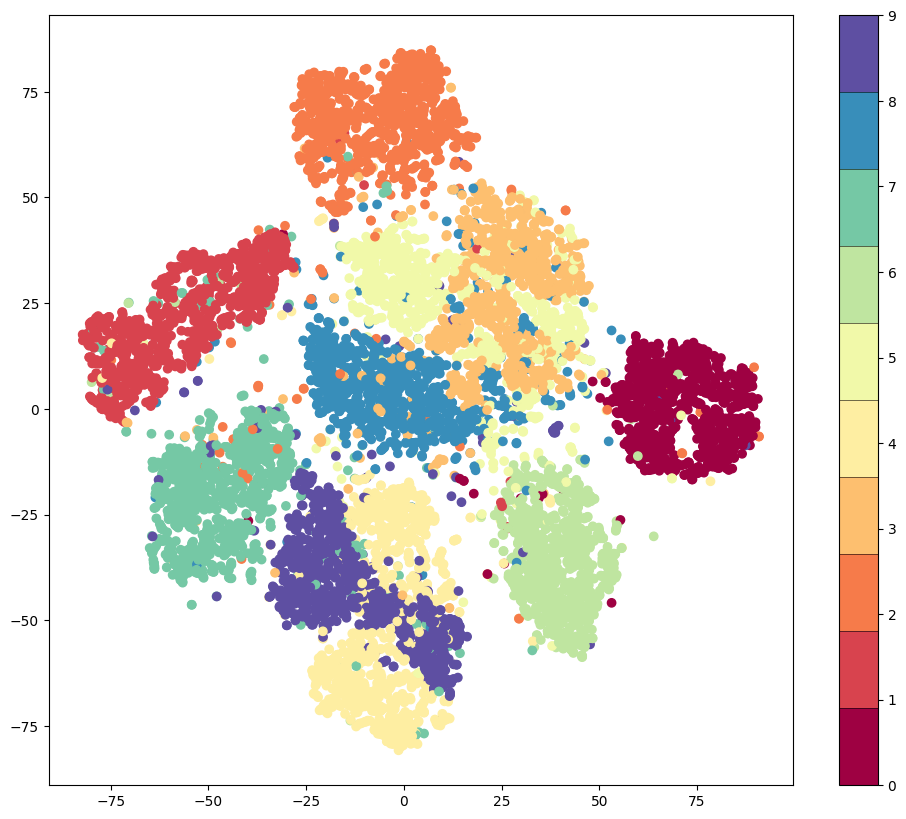

In [11]:
from sklearn.manifold import TSNE

latent_vectors = []
classes = []

for im, clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im), -1))
    classes.extend(clss)

latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()


tsne = TSNE(2)
clustered = tsne.fit_transform(latent_vectors)

fig = plt.figure(figsize=(12, 10))
cmap = plt.get_cmap("Spectral", 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

/home/xujialiu/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


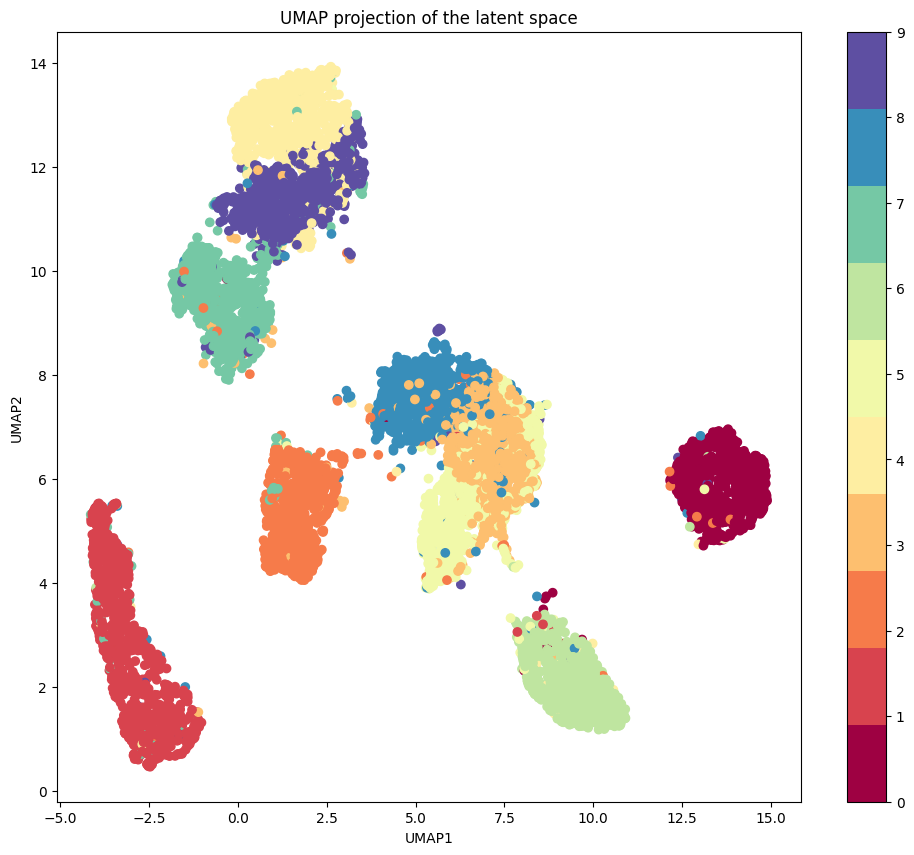

In [12]:
import umap


latent_vectors = []
classes = []

for im, clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im), -1))
    classes.extend(clss)

latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

# 使用UMAP替代TSNE
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(latent_vectors)

# 绘图
fig = plt.figure(figsize=(12, 10))
cmap = plt.get_cmap("Spectral", 10)
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=classes, cmap=cmap)
plt.colorbar(scatter)
plt.title("UMAP projection of the latent space")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()